In [20]:
import pandas as pd

# Load the uploaded Excel file
file_path = 'Adjusted_synlung_trainset.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,~,AGE,Adenocarcinoma,Large cell carcinoma,Squamous cell carcinoma,TX,T0,T1,T1a,T1b,...,Height,Weight,FEV1_FVC_P,DLCO_VA_P,EGFR mutation Detection,Operation,Chemotherapy,Radiation Therapy,Death,Survival period
0,0,72,1,1,0,1,0,0,0,0,...,142.0,68.2,87,102,99,1,0,0,0,157
1,1,66,1,0,0,0,0,1,0,0,...,179.4,61.1,54,112,99,0,1,0,0,567
2,2,75,1,1,0,1,0,0,0,0,...,169.8,73.8,79,73,99,0,1,0,0,253
3,3,77,1,0,1,0,0,1,0,0,...,158.5,79.1,78,137,1,0,0,0,0,266
4,4,85,1,0,0,0,0,0,0,0,...,172.3,44.3,48,85,99,1,0,1,0,470


In [23]:
data.info()
#모두 int나 float으로 숫자로 되어있지만 범주형 속성들이 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ~                        10000 non-null  int64  
 1   AGE                      10000 non-null  int64  
 2   Adenocarcinoma           10000 non-null  int64  
 3   Large cell carcinoma     10000 non-null  int64  
 4   Squamous cell carcinoma  10000 non-null  int64  
 5   TX                       10000 non-null  int64  
 6   T0                       10000 non-null  int64  
 7   T1                       10000 non-null  int64  
 8   T1a                      10000 non-null  int64  
 9   T1b                      10000 non-null  int64  
 10  T1c                      10000 non-null  int64  
 11  T2                       10000 non-null  int64  
 12  T2a                      10000 non-null  int64  
 13  T2b                      10000 non-null  int64  
 14  T3                     

In [34]:
# 세 변수의 조합에 따른 새로운 인덱스 생성
data['Cancer_Index'] = (
    data['Adenocarcinoma'].astype(str) + 
    data['Large cell carcinoma'].astype(str) + 
    data['Squamous cell carcinoma'].astype(str)
)

# 각 조합별 개수 계산
cancer_index_counts = data['Cancer_Index'].value_counts()

# 결과를 DataFrame으로 정리
cancer_index_df = cancer_index_counts.reset_index()
cancer_index_df.columns = ['Cancer_Index', 'Count']


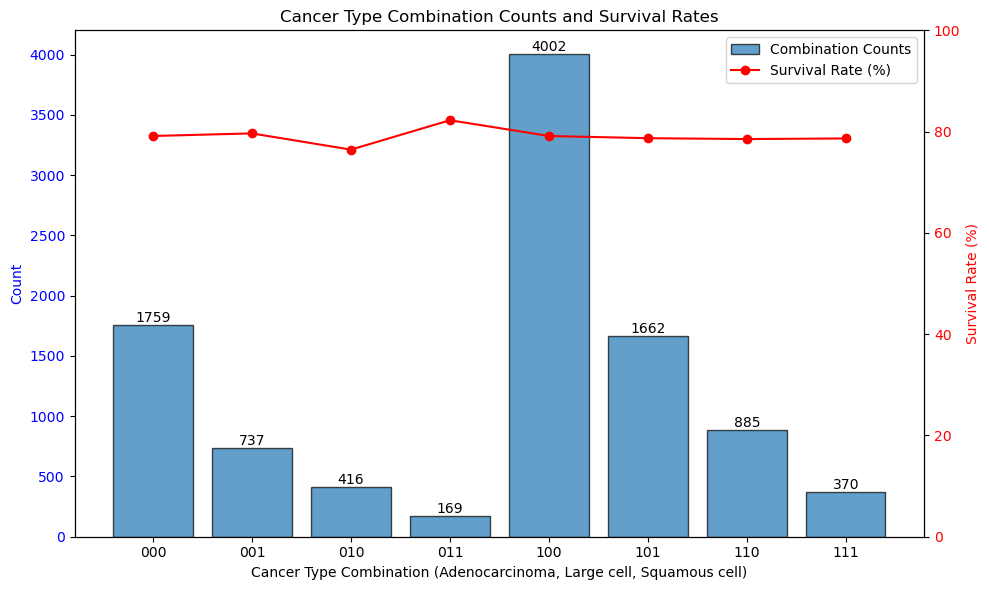

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
data_path = 'Adjusted_synlung_trainset.xlsx'  # 로컬 경로에 맞게 수정
data = pd.read_excel(data_path)

# 암 조합 인덱스 생성
data['Cancer_Index'] = (
    data['Adenocarcinoma'].astype(str) + 
    data['Large cell carcinoma'].astype(str) + 
    data['Squamous cell carcinoma'].astype(str)
)

# 각 조합별 개수 및 생존율 계산
cancer_survival = data.groupby('Cancer_Index').agg(
    Total=('Death', 'size'), 
    Deaths=('Death', 'sum')
).reset_index()

# 생존율 추가 (생존율 = 생존자 / 전체)
cancer_survival['Survival_Rate'] = (1 - cancer_survival['Deaths'] / cancer_survival['Total']) * 100

# 그래프 시각화 (왼쪽: 암종류 조합별 분포, 오른쪽: 생존율)
fig, ax1 = plt.subplots(figsize=(10, 6))

# 왼쪽 y축: 암 조합별 분포
bars = ax1.bar(cancer_survival['Cancer_Index'], cancer_survival['Total'], alpha=0.7, edgecolor='black', label='Combination Counts')
ax1.set_xlabel('Cancer Type Combination (Adenocarcinoma, Large cell, Squamous cell)')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Cancer Type Combination Counts and Survival Rates')

# 막대 위에 count 값 표시
for bar, count in zip(bars, cancer_survival['Total']):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

# 오른쪽 y축: 생존율 (0~100 scale)
ax2 = ax1.twinx()
ax2.plot(cancer_survival['Cancer_Index'], cancer_survival['Survival_Rate'], color='red', marker='o', label='Survival Rate (%)', linestyle='-')
ax2.set_ylabel('Survival Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100)  # 생존율을 0~100으로 맞춤

# 범례 추가
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()


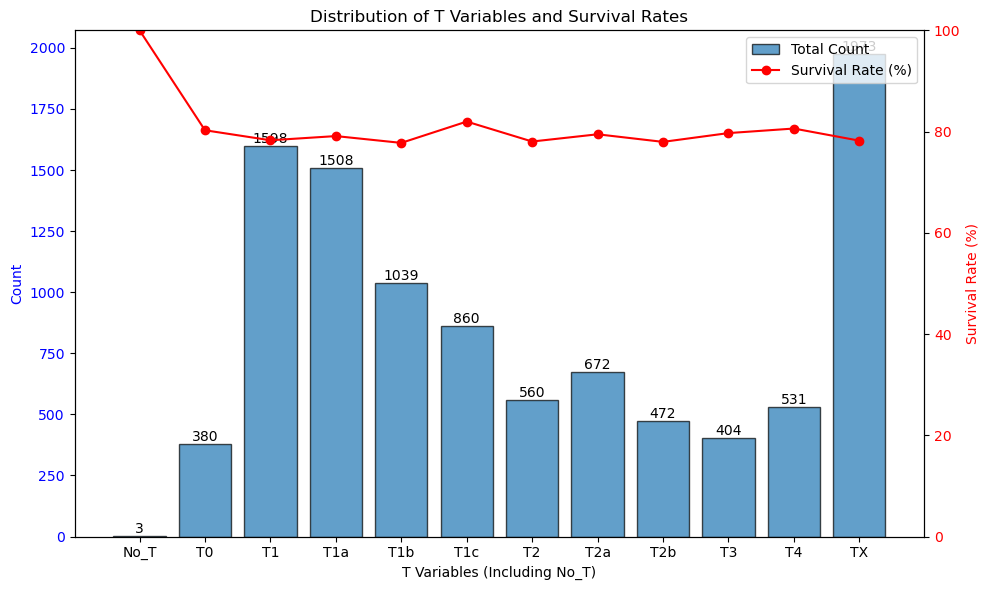

In [50]:
# 관심 있는 T 변수와 No_T 추가
columns_of_interest = ['TX', 'T0', 'T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4']
data['No_T'] = (data[columns_of_interest].sum(axis=1) == 0).astype(int)

# T 변수들과 No_T의 생존율 계산
t_survival = data[columns_of_interest + ['No_T', 'Death']].melt(
    id_vars=['Death'],
    value_vars=columns_of_interest + ['No_T'],
    var_name='T_Variable',
    value_name='Presence'
).query('Presence == 1').groupby('T_Variable').agg(
    Total=('Death', 'size'),
    Deaths=('Death', 'sum')
).reset_index()

# 생존율 계산
t_survival['Survival_Rate'] = (1 - t_survival['Deaths'] / t_survival['Total']) * 100

# 왼쪽 y축: 각 T 변수의 빈도
fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(t_survival['T_Variable'], t_survival['Total'], alpha=0.7, edgecolor='black', label='Total Count')
ax1.set_xlabel('T Variables (Including No_T)')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Distribution of T Variables and Survival Rates')

# 막대 위에 count 값 표시
for bar, count in zip(bars, t_survival['Total']):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

# 오른쪽 y축: 각 T 변수의 생존율
ax2 = ax1.twinx()
ax2.plot(t_survival['T_Variable'], t_survival['Survival_Rate'], color='red', marker='o', label='Survival Rate (%)', linestyle='-')
ax2.set_ylabel('Survival Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100)  # 생존율 0~100으로 설정

# 범례 추가
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()

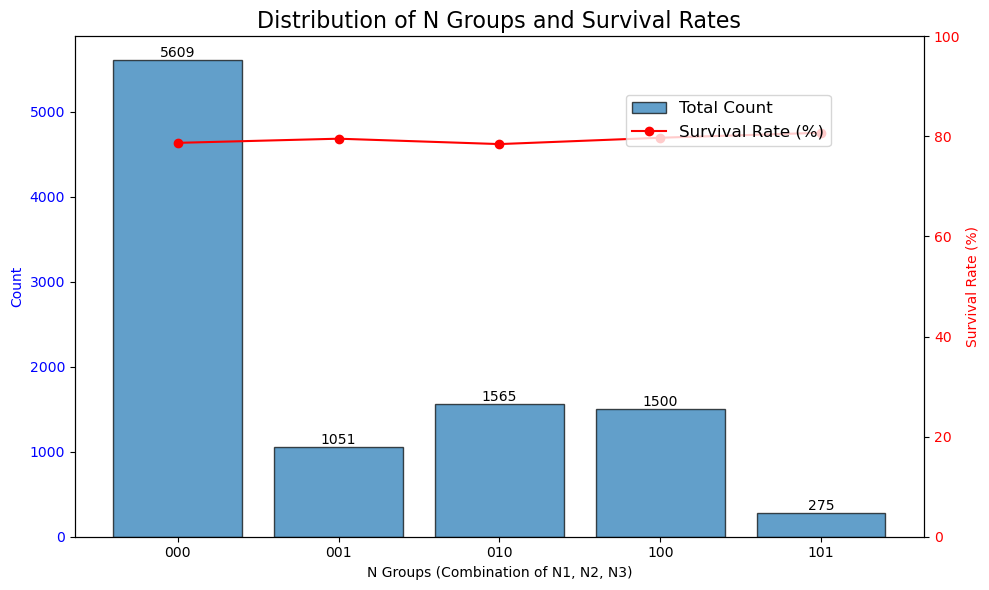

In [54]:

# Generate 'N_Group' and calculate survival rates
data['N_Group'] = (
    data['N1'].astype(str) +
    data['N2'].astype(str) +
    data['N3'].astype(str)
)

n_group_survival = data.groupby('N_Group').agg(
    Total=('Death', 'size'),
    Deaths=('Death', 'sum')
).reset_index()
n_group_survival['Survival_Rate'] = (1 - n_group_survival['Deaths'] / n_group_survival['Total']) * 100

# Create the visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: Total count
bars = ax1.bar(n_group_survival['N_Group'], n_group_survival['Total'], alpha=0.7, edgecolor='black', label='Total Count')
ax1.set_xlabel('N Groups (Combination of N1, N2, N3)')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Distribution of N Groups and Survival Rates', fontsize=16)

# Annotate count on top of bars
for bar, count in zip(bars, n_group_survival['Total']):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

# Right y-axis: Survival rate
ax2 = ax1.twinx()
ax2.plot(n_group_survival['N_Group'], n_group_survival['Survival_Rate'], color='red', marker='o', label='Survival Rate (%)', linestyle='-')
ax2.set_ylabel('Survival Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100)

# Legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), bbox_transform=ax1.transAxes, fontsize=12)

plt.tight_layout()
plt.show()


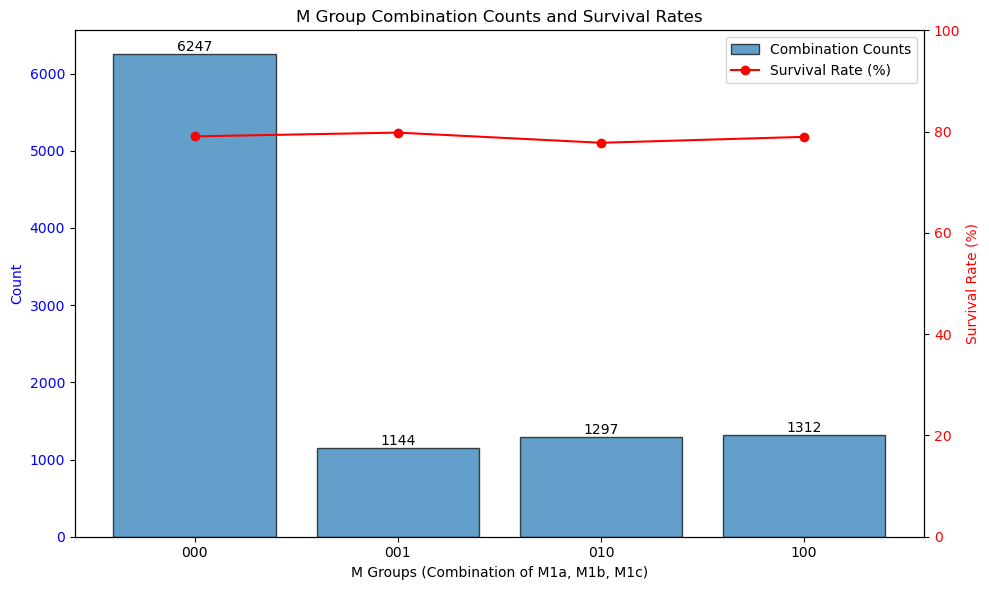

In [53]:
# M 조합 인덱스 생성
data['M_Group'] = (
    data['M1a'].astype(str) +
    data['M1b'].astype(str) +
    data['M1c'].astype(str)
)

# 각 조합별 개수 및 생존율 계산
m_group_survival = data.groupby('M_Group').agg(
    Total=('Death', 'size'),
    Deaths=('Death', 'sum')
).reset_index()

# 생존율 추가 (생존율 = 생존자 / 전체)
m_group_survival['Survival_Rate'] = (1 - m_group_survival['Deaths'] / m_group_survival['Total']) * 100

# 그래프 시각화 (왼쪽: M 조합별 분포, 오른쪽: 생존율)
fig, ax1 = plt.subplots(figsize=(10, 6))

# 왼쪽 y축: M 조합별 분포
bars = ax1.bar(m_group_survival['M_Group'], m_group_survival['Total'], alpha=0.7, edgecolor='black', label='Combination Counts')
ax1.set_xlabel('M Groups (Combination of M1a, M1b, M1c)')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('M Group Combination Counts and Survival Rates')

# 막대 위에 count 값 표시
for bar, count in zip(bars, m_group_survival['Total']):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

# 오른쪽 y축: 생존율 (0~100 scale)
ax2 = ax1.twinx()
ax2.plot(m_group_survival['M_Group'], m_group_survival['Survival_Rate'], color='red', marker='o', label='Survival Rate (%)', linestyle='-')
ax2.set_ylabel('Survival Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100)  # 생존율을 0~100으로 맞춤

# 범례 추가
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()


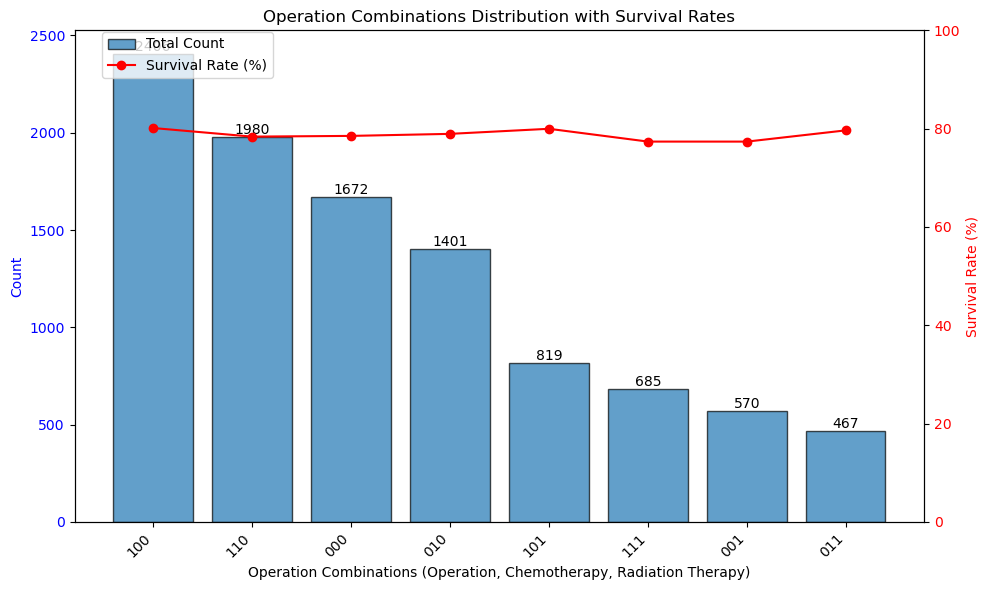

In [59]:
# Operation-related columns
operation_columns = ['Operation', 'Chemotherapy', 'Radiation Therapy']

# Create a combination column representing '000', '100', etc.
data['Operation_Combination'] = (
    data['Operation'].astype(str) +
    data['Chemotherapy'].astype(str) +
    data['Radiation Therapy'].astype(str)
)

# Calculate count and survival rate for each combination
operation_combinations_df = data.groupby('Operation_Combination').agg(
    Total=('Death', 'size'),
    Deaths=('Death', 'sum')
).reset_index()

# Calculate survival rate
operation_combinations_df['Survival_Rate'] = (
    (1 - operation_combinations_df['Deaths'] / operation_combinations_df['Total']) * 100
)

# Sort the combinations for better visualization
operation_combinations_df = operation_combinations_df.sort_values(by='Total', ascending=False)

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis: Total count
bars = ax1.bar(operation_combinations_df['Operation_Combination'], operation_combinations_df['Total'], alpha=0.7, edgecolor='black', label='Total Count')
ax1.set_xlabel('Operation Combinations (Operation, Chemotherapy, Radiation Therapy)')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Operation Combinations Distribution with Survival Rates')
plt.xticks(rotation=45, ha='right', fontsize=10)

# Annotate count on top of bars
for bar, count in zip(bars, operation_combinations_df['Total']):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

# Right y-axis: Survival rate
ax2 = ax1.twinx()
ax2.plot(operation_combinations_df['Operation_Combination'], operation_combinations_df['Survival_Rate'], color='red', marker='o', label='Survival Rate (%)', linestyle='-')
ax2.set_ylabel('Survival Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100)

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))

plt.tight_layout()
plt.show()


In [61]:
numeric_columns = ['AGE', 'Height', 'Weight', 'FEV1_FVC_P', 'DLCO_VA_P', 'Survival period']

# Compute the correlation matrix
correlation_matrix = data[numeric_columns].corr()
correlation_matrix

,AGE,Height,Weight,FEV1_FVC_P,DLCO_VA_P,Survival period
AGE,1.000000,0.004020,-0.010590,0.008117,0.011267,0.001747
Height,0.004020,1.000000,0.008054,-0.018251,0.008934,0.005531
Weight,-0.010590,0.008054,1.000000,0.011563,0.004287,0.008670
FEV1_FVC_P,0.008117,-0.018251,0.011563,1.000000,0.012560,0.003600
DLCO_VA_P,0.011267,0.008934,0.004287,0.012560,1.000000,0.010170
Survival period,0.001747,0.005531,0.008670,0.003600,0.010170,1.000000


In [68]:
data['FEV1_FVC_P'].unique()

array([87, 54, 79, 78, 48, 85, 64, 52, 91, 88, 44, 80, 81, 83, 47, 69, 42,
       45, 66, 90, 59, 96, 86, 37, 71, 77, 41, 98, 65, 39, 73, 94, 51, 43,
       31, 74, 93, 97, 84, 62, 82, 67, 70, 76, 53, 50, 55, 36, 68, 57, 63,
       61, 58, 75, 72, 95, 46, 56, 60, 49, 89, 99, 92], dtype=int64)

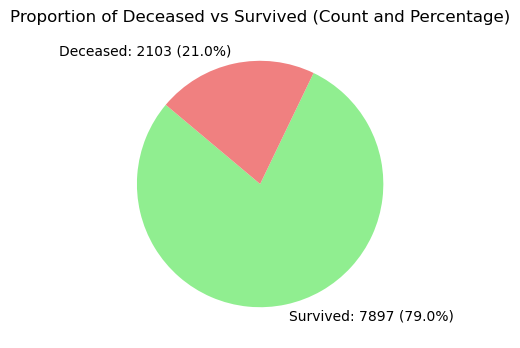

In [71]:
# 데이터 상 산사람 죽은사람 비율
survival_counts = data['Death'].value_counts()
labels = ['Survived', 'Deceased']
colors = ['lightgreen', 'lightcoral']

counts = survival_counts.values
percentages = survival_counts / survival_counts.sum() * 100
labels_with_counts = [f"{label}: {count} ({percentage:.1f}%)"
                      for label, count, percentage in zip(labels, counts, percentages)]

# Plot the pie chart with updated labels
plt.figure(figsize=(4, 4))
plt.pie(survival_counts, labels=labels_with_counts, autopct='', startangle=140, colors=colors)
plt.title('Proportion of Deceased vs Survived (Count and Percentage)')
plt.show()

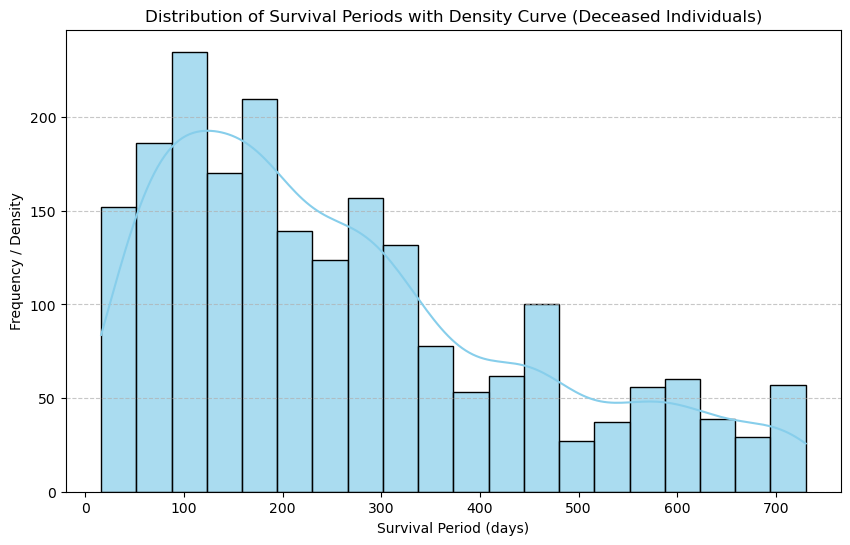

In [75]:
import seaborn as sns
#  사망자의 생존기간 분포
deceased_data = data[data['Death'] == 1]

# Plot the histogram with a density curve
plt.figure(figsize=(10, 6))

# Plot histogram
sns.histplot(deceased_data['Survival period'], bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.7)

# Add title and labels
plt.title('Distribution of Survival Periods with Density Curve (Deceased Individuals)')
plt.xlabel('Survival Period (days)')
plt.ylabel('Frequency / Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

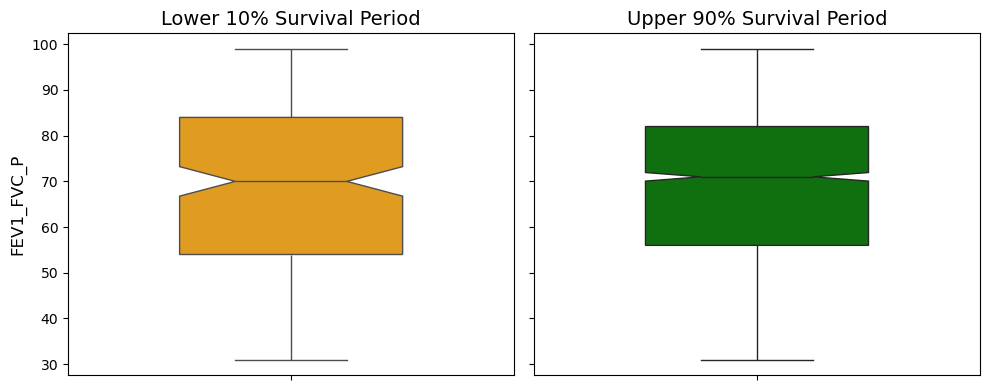

In [86]:
# 사망자 중 생존기간이 하위 10프로 이하인 사람들의 FEV1_FVC_P 분포 비교

# Calculate the 10th percentile of survival periods for deceased individuals
lower_10_percentile = deceased_data['Survival period'].quantile(0.1)

# Separate the data into two groups based on the 10th percentile
lower_10_group = deceased_data[deceased_data['Survival period'] <= lower_10_percentile]
upper_90_group = deceased_data[deceased_data['Survival period'] > lower_10_percentile]

# Plot two boxplots side by side for better comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot for lower 10% group
sns.boxplot(ax=axes[0], y=lower_10_group['FEV1_FVC_P'], color='orange', notch=True, width=0.5)
axes[0].set_title('Lower 10% Survival Period', fontsize=14)
axes[0].set_ylabel('FEV1_FVC_P', fontsize=12)

# Plot for upper 90% group
sns.boxplot(ax=axes[1], y=upper_90_group['FEV1_FVC_P'], color='green', notch=True, width=0.5)
axes[1].set_title('Upper 90% Survival Period', fontsize=14)
axes[1].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()


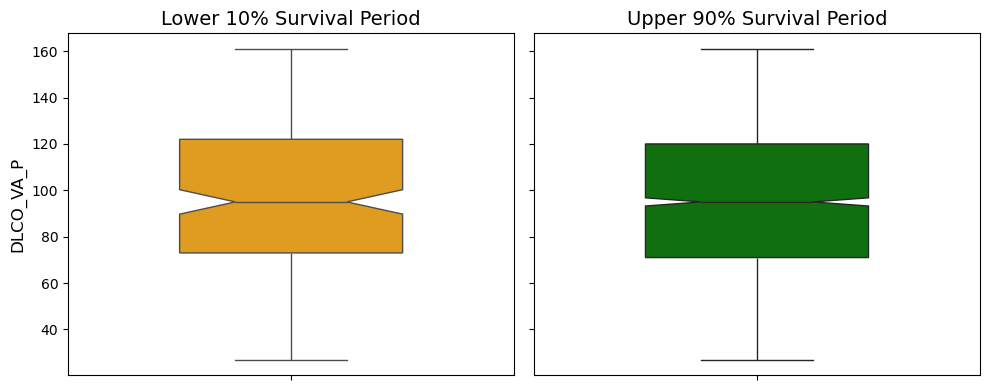

In [87]:
# Plot two boxplots for DLCO_VA_P side by side for better comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot for lower 10% group
sns.boxplot(ax=axes[0], y=lower_10_group['DLCO_VA_P'], color='orange', notch=True, width=0.5)
axes[0].set_title('Lower 10% Survival Period', fontsize=14)
axes[0].set_ylabel('DLCO_VA_P', fontsize=12)

# Plot for upper 90% group
sns.boxplot(ax=axes[1], y=upper_90_group['DLCO_VA_P'], color='green', notch=True, width=0.5)
axes[1].set_title('Upper 90% Survival Period', fontsize=14)
axes[1].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

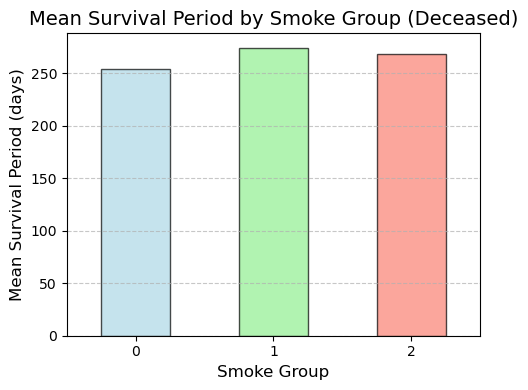

In [ ]:
# 흡연 유형별 생존 기간의 평균 (0 : 비흡연자, 1: 흡연자, 2: 과거 흡연자 )

# Calculate the mean survival period for each smoke group
smoke_means = deceased_data.groupby('Smoke')['Survival period'].mean()

# Plot the mean survival periods
plt.figure(figsize=(5, 4))
smoke_means.plot(kind='bar', color=['lightblue', 'lightgreen', 'salmon'], edgecolor='black', alpha=0.7)
plt.title('Mean Survival Period by Smoke Group (Deceased)', fontsize=14)
plt.xlabel('Smoke Group', fontsize=12)
plt.ylabel('Mean Survival Period (days)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [91]:
from scipy.stats import f_oneway

# Group the survival period by smoke status (0, 1, 2) for deceased individuals
smoke_groups = deceased_data.groupby('Smoke')['Survival period'].apply(list)

# Perform one-way ANOVA
anova_result = f_oneway(*smoke_groups)

anova_result

# 3그룹 anova 1원분석 그룹의 평균에 차이가 있는지 확인 : p값 0.05 이상이므로 유의미하다고 볼 수 없음

F_onewayResult(statistic=1.4032867618651872, pvalue=0.24601817204220724)